In [25]:
# Basic operating system (os), numerical, and plotting functionality
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from random import randint
import gradio as gr
import cv2
import functools

# import emnist
from emnist import list_datasets
from emnist import extract_training_samples
from emnist import extract_test_samples

from sklearn.utils import shuffle

# Feature extractors and classification algorithm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.preprocessing.image import img_to_array

# scikit-learn performance metric utilities
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

In [2]:
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

In [3]:
# get training and testing data and labels from the emnist balanced datset
training_images, training_labels = extract_training_samples("balanced")
testing_images, testing_labels = extract_test_samples("balanced")

In [4]:
# letters in the correct order so that they can be indexed using the labels
class_mapping = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'

g


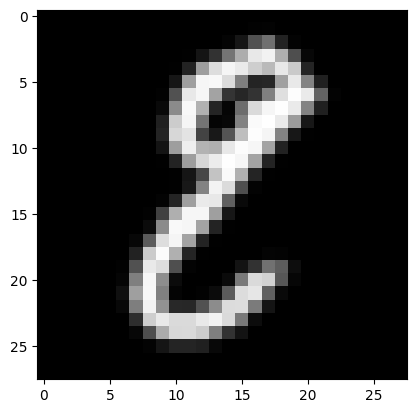

In [5]:
# display an image for reference
index = randint(0, training_images.shape[0] - 1)
plt.imshow(training_images[index], cmap="gray")
print(class_mapping[training_labels[index]])

In [6]:
# flatten each training image and store in each row of a dataframe
#training_images, training_labels = shuffle(training_images, training_labels)
data_size = 10000
train_array = np.zeros((data_size, training_images.shape[1]**2))
train_labels = np.zeros(data_size)
for index in range(data_size):
    train_array[index] = training_images[index].flatten()
    train_labels[index] = training_labels[index]
train_data = pd.DataFrame(train_array)

In [7]:
# get a subset of the testing data, flatten each testing image and store in each row of a dataframe
test_data_size = 6000
test_array = np.zeros((test_data_size, testing_images.shape[1]**2))
test_labels = np.zeros(test_data_size)
for index in range(test_data_size):
    test_array[index] = testing_images[index].flatten()
    test_labels[index] = testing_labels[index]
test_data = pd.DataFrame(test_array)

In [23]:
# create and fit decision tree
decision_tree = DecisionTreeClassifier(criterion="entropy", random_state = None, min_samples_leaf = 3)
decision_tree.fit(train_data, train_labels)

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=3)

In [24]:
# print accuracy of decision tree
y_train_pred=decision_tree.predict(train_data)
print("Training Accuracy is ", accuracy_score(train_labels, y_train_pred)*100)
y_val_pred=decision_tree.predict(test_data)
print("Validation Accuracy is ", accuracy_score(test_labels,y_val_pred)*100)

Training Accuracy is  85.27
Validation Accuracy is  47.65


In [8]:
# display image, prediction, confidence
def display_prediction(image, expected, label):
    plt.imshow(image, cmap="gray")
    plt.title("prediction: " + class_mapping[int(label)] + " actual: " + class_mapping[int(expected)])
    plt.show()

In [9]:
# creating a model w sklearn's RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=60)

# training/fitting the model with training data
random_forest.fit(train_data, train_labels)

RandomForestClassifier(n_estimators=60)

In [10]:
#printing accuracy of testing & training data
forest_train_pred=random_forest.predict(train_data)
print("Training Accuracy is ", accuracy_score(train_labels, forest_train_pred)*100)
forest_val_pred=random_forest.predict(test_data)
print("Validation Accuracy is ", accuracy_score(test_labels,forest_val_pred)*100)

Training Accuracy is  100.0
Validation Accuracy is  71.15


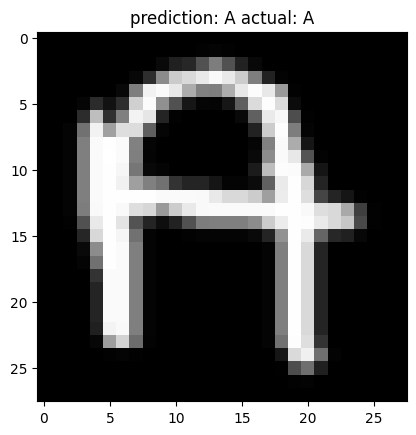

In [11]:
# randomly selects an image from test dataset, shows it and the predicted/actual label
index = randint(0, test_data.shape[0] - 1)
display_prediction(testing_images[index], test_labels[index], forest_val_pred[index])

In [12]:
# used to get an array with the letter corresponding to the label number 
def get_class_labels(arr):
    class_labels = np.chararray(arr.shape)
    for i, ele in enumerate(arr):
        class_labels[i] = class_mapping[int(ele)]
    return class_labels

In [13]:
# get confusion matrix data
matrix = confusion_matrix(get_class_labels(test_labels), get_class_labels(forest_val_pred))

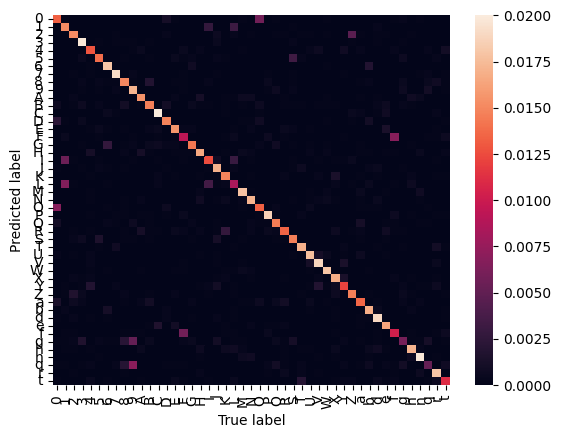

In [14]:
# show confusion matrix with actual label on the x-axis and the predicted one on the y-axi
sns.heatmap(matrix/np.sum(matrix), xticklabels=list(class_mapping), yticklabels=list(class_mapping))
plt.xlabel('True label')
plt.ylabel('Predicted label')

In [16]:
# define function to classify an input image from gradio
def classify_image(input):
    updated_image = input.reshape((1, 784))
    prediction = random_forest.predict(updated_image)
    return str(class_mapping[int(prediction[0])])

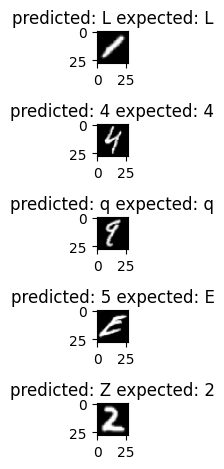

In [17]:
# use classify_image to randomly select 5 images to display as a subplot
for i in range(5):
    index = randint(0, test_data.shape[0] - 1)
    plt.subplot(5, 1, i + 1)
    plt.title("predicted: " + classify_image(testing_images[index]) + " expected: " + str(class_mapping[testing_labels[index]]))
    plt.imshow(testing_images[index], cmap="gray")
plt.tight_layout()
plt.show()

In [18]:
TARGET_HEIGHT = 28
TARGET_WIDTH = 28

In [251]:
def classify_word(input):
    # final word/string to return 
    classification = ""
    # apply thresholding to make differences between characters and background more obvious
    image = cv2.imwrite('file.jpg', input)
    image = cv2.imread('file.jpg', 0)
    ret, threshold = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)
    # find contours and get bounding box
    contours, _ = cv2.findContours(threshold.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boundingBoxes = [cv2.boundingRect(contour) for contour in contours]

    # sort bounding boxes from left to right and top to bottom so characters are read in the correct order
    boundingBoxes=sorted(boundingBoxes, key=functools.cmp_to_key(compare))
    # loop over bounding boxes
    for rect in boundingBoxes:
        # get coordinates from the bounding box
        x, y, w, h = rect
        # only process if size of character is large enough
        if w * h > 20:
            # crop to only have the character
            crop = image[y:y+h, x:x+w]

            # ensure each character is the correct size for our model (28 x 28) by adding padding
            rows = crop.shape[0]
            columns = crop.shape[1]
            paddingX = (TARGET_HEIGHT - rows) // 2 if rows < TARGET_HEIGHT else rows
            paddingY = (TARGET_WIDTH - columns) // 2 if columns < TARGET_WIDTH else columns

            # add padding 
            crop = cv2.copyMakeBorder(crop, paddingY, paddingY, paddingX, paddingX, cv2.BORDER_CONSTANT, None, value=0)

            # convert and resize image to target height and width
            crop = cv2.resize(crop, (TARGET_WIDTH, TARGET_HEIGHT))

            # format image data to make prediction
            crop = img_to_array(crop)
            char = crop.reshape((1, 784))

            # make prediction, add to classification string
            prediction = random_forest.predict(char)
            classification += str(class_mapping[int(prediction[0])])
    return classification

def compare(rect1, rect2):
    if abs(rect1[1] - rect2[1]) > 10:
        return rect1[1] - rect2[1]
    else:
        return rect1[0] - rect2[0]

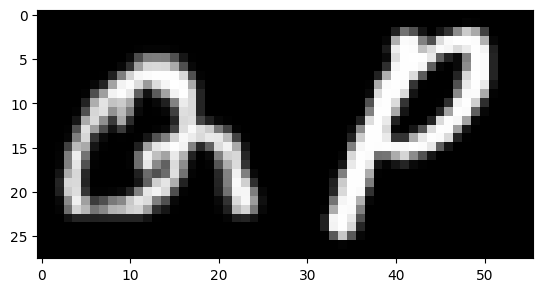

In [252]:
index1 = randint(0, test_data.shape[0] - 1)
index2 = randint(0, test_data.shape[0] - 1)
new_image = np.concatenate((testing_images[index1],testing_images[index2]), 1)
new_label = class_mapping[int(test_labels[index1])] + class_mapping[int(testing_labels[index2])]
#display_prediction(new_image, new_label[index], forest_val_pred[index])
plt.imshow(new_image, cmap='gray')

In [255]:
print("actual: ", new_label)
print(classify_word(new_image))

actual:  QP
[16.]
[25.]
GP


[(0, 8, 2, 2), (0, 0, 24, 28), (8, 3, 2, 5), (9, 0, 1, 2), (11, 0, 1, 1), (13, 0, 2, 1), (0, 23, 2, 1), (3, 21, 2, 2), (5, 19, 2, 1), (20, 13, 3, 3), (23, 10, 1, 1), (15, 26, 1, 2)]
[21.]
L


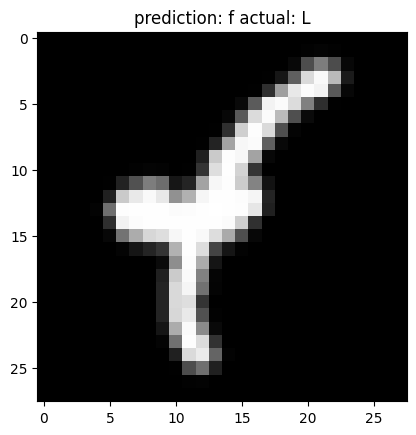

In [199]:
# randomly selects an image from test dataset, shows it and the predicted/actual label
index = randint(0, test_data.shape[0] - 1)
display_prediction(testing_images[index], test_labels[index], forest_val_pred[index])
print(classify_word(testing_images[index]))

In [254]:
# images = sketchpad to draw on, label = prints prediction
image = gr.inputs.Image(shape=(50, 50), image_mode="L", invert_colors=True, source="canvas", type="numpy")
label = gr.outputs.Textbox(type="str")

gr.Interface(fn=classify_word, inputs=image, outputs=label, capture_session=True).launch(share=True)

Running on local URL:  http://127.0.0.1:7863/
Running on public URL: https://29971.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7863/',
 'https://29971.gradio.app')

In [38]:
# images = sketchpad to draw on, label = prints prediction
image = gr.inputs.Image(shape=(28, 28), image_mode="L", invert_colors=True, source="canvas", type="numpy")
label = gr.outputs.Textbox(type="str")

gr.Interface(fn=classify_image, inputs=image, outputs=label, capture_session=True).launch(share=True)

Running on local URL:  http://127.0.0.1:7863/
Running on public URL: https://39387.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7863/',
 'https://39387.gradio.app')